In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
!pip install flask-ngrok

In [3]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 49.8 MB/s eta 0:00:00


In [4]:
%load_ext tensorboard

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from torch.optim import Adam
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint  # ModelCheckpoint 임포트
from pytorch_lightning.callbacks.early_stopping import EarlyStopping  # EarlyStopping 콜백도 임포트

In [6]:
# Google Drive에서 데이터 로드
train_data_path = "/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/train_data.csv"
test_data_path = "/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/test_data.csv"

# 데이터 로드
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

# 스케일링
scaler = MinMaxScaler()
df_train['feed_pressure'] = scaler.fit_transform(df_train[['feed_pressure']])
df_test['feed_pressure'] = scaler.transform(df_test[['feed_pressure']])

# 시간 인덱스 추가
df_train['time_idx'] = range(len(df_train))
df_test['time_idx'] = range(len(df_train), len(df_train) + len(df_test))

# 학습 및 테스트 데이터 병합
df_total = pd.concat([df_train, df_test], ignore_index=True)

In [7]:
# 테스트 데이터 길이 출력
test_data_length = len(df_train) + len(df_test)
print(f"Test data length: {test_data_length}")


Test data length: 11158


### 데이터 준비 및 설정
우선 max_encoder_length와 max_prediction_length를 설정하여 데이터의 인코더 및 예측 길이를 정의합니다.

In [8]:
# max_encoder_length와 max_prediction_length 설정
max_encoder_length = 500  #12시간
max_prediction_length = 1  #2시간

print(f"Max encoder length: {max_encoder_length} entries")
print(f"Max prediction length: {max_prediction_length} entries")

# 그룹 ID 설정
df_total["group"] = "series"  # 단일 시계열일 경우 고유 그룹 지정

Max encoder length: 500 entries
Max prediction length: 1 entries


### TimeSeriesDataSet 생성
TimeSeriesDataSet을 사용해 데이터를 생성합니다. 여기에는 타겟, 그룹화 방식, 그리고 변동하는 시계열 컬럼을 정의합니다.


In [9]:
training = TimeSeriesDataSet(
    df_total[lambda x: x.time_idx < len(df_train)],  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",  # 타겟 변수
    group_ids=["group"],  # 그룹화
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 관련 변수
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

### DataLoader 생성
DataLoader를 생성하여 모델이 데이터를 학습할 수 있도록 준비합니다.

In [10]:
# 데이터 로더 재생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=32, num_workers=0)

### Temporal Fusion Transformer 모델 생성
Temporal Fusion Transformer 모델을 생성하여 데이터셋을 학습할 준비를 합니다.

In [18]:
from torchmetrics import MeanAbsoluteError

# Define the loss function
loss = MeanAbsoluteError()

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,  # 학습률
    hidden_size=16,  # 모델의 잠재 표현 크기
    attention_head_size=1,  # 어텐션 헤드 개수 (패턴 포착)
    dropout=0.1,  # 과적합 방지
    hidden_continuous_size=16,  # 연속형 변수의 임베딩 크기
    loss=loss,  # 손실 함수 (loss 변수 사용)
    log_interval=10,  # 학습 로그 출력 빈도
    reduce_on_plateau_patience=3,  # 손실이 개선되지 않을 시 학습률 줄이는 시점
    optimizer="adam"
)

### LightningModule 정의 및 Trainer 설정
PyTorch Lightning을 이용하여 모델 학습을 보다 쉽게 관리할 수 있도록 합니다.


In [13]:
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model
        self.train()  # 명시적으로 학습 모드로 설정

    def forward(self, x):
        # 모든 입력 데이터를 모델의 디바이스로 이동
        x = {key: value.to(self.device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        # 모든 데이터를 모델의 디바이스로 이동
        self.train()  # 학습 스텝에서 다시 학습 모드로 전환
        x, y = batch
        x = {key: value.to(self.device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}

        # y가 튜플인 경우, 첫 번째 요소만 가져오기
        if isinstance(y, tuple):
            y = y[0]
        y = y.to(self.device)

        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 모든 데이터를 모델의 디바이스로 이동
        x, y = batch
        x = {key: value.to(self.device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}

        # y가 튜플인 경우, 첫 번째 요소만 가져오기
        if isinstance(y, tuple):
            y = y[0]
        y = y.to(self.device)

        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.03)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]


## 모델 학습

In [24]:
# Google Drive가 체크폰트 저장 경로 설정
local_checkpoint_dir = "/content/checkpoints/"
drive_checkpoint_dir = "/content/drive/MyDrive/종설프1_5팀/checkpoints/"
os.makedirs(local_checkpoint_dir, exist_ok=True)
os.makedirs(drive_checkpoint_dir, exist_ok=True)

# 모델 저장
model_save_path = "/content/drive/MyDrive/종설프1_5팀/model.pth"

# 기존 체크폰트 파일 삭제 함수
def delete_existing_checkpoints(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        for filename in os.listdir(checkpoint_dir):
            file_path = os.path.join(checkpoint_dir, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    print(f"Deleted checkpoint file: {file_path}")
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")


# 가장 최근 체크포인트 찾기
def get_latest_checkpoint(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        checkpoints = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]
        if checkpoints:
            return max(checkpoints, key=os.path.getctime)  # 가장 최근 파일 반환
    return None

In [25]:
# TFT 모델을 TFTWrapper로 감싸기
tft.to('cuda')
wrapped_tft = TFTWrapper(tft).to('cuda')

# Early Stopping Callback 추가
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=True,
    mode="min"
)

# Trainer 설정
trainer = Trainer(
    max_epochs=30,
    accelerator="gpu",  # GPU만 사용하도록 설정
    devices=1,
    gradient_clip_val=0.3,
    precision=32  # 정밀도를 32-bit로 설정
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<span style="color:red;">주의: 체크포인트 삭제!</span>

In [26]:
# 기존 체크포인트에서 로드 여부 확인 및 학습 실행
delete_checkpoints = input("기존 체크포인트 파일을 삭제하시겠습니까? (y/n): ").lower()

if delete_checkpoints == 'y':
    print("기존 체크포인트 파일을 삭제합니다.")
    delete_existing_checkpoints(local_checkpoint_dir)
    delete_existing_checkpoints(drive_checkpoint_dir)

    # 새 학습 시작
    trainer.fit(
        model=wrapped_tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

else:
    print("기존 체크포인트를 유지합니다.")
    latest_checkpoint = get_latest_checkpoint(local_checkpoint_dir)

    if latest_checkpoint:
        print(f"기존 체크포인트에서 로드합니다: {latest_checkpoint}")

        # 체크포인트에서 모델 로드
        loaded_tft = TemporalFusionTransformer.load_from_checkpoint(latest_checkpoint)

        # TFTWrapper로 래핑
        wrapped_tft = TFTWrapper(tft_model=loaded_tft).to(device)

        # 기존 체크포인트에서 로드한 모델로 학습 재개
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )

    else:
        print("체크포인트가 없습니다. 새로 학습을 시작합니다.")

        # 새 학습 시작
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )


기존 체크포인트 파일을 삭제하시겠습니까? (y/n): n


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 17.7 K | train
----------------------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
160       Modules in train mode
0         Modules in eval mode


기존 체크포인트를 유지합니다.
체크포인트가 없습니다. 새로 학습을 시작합니다.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## 서버구축

In [34]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2024-11-27 01:02:20--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 13.248.244.96, 75.2.60.68, 35.71.179.82, ...
Connecting to bin.equinox.io (bin.equinox.io)|13.248.244.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  20.8MB/s    in 0.6s    

2024-11-27 01:02:21 (20.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
!./ngrok authtoken <YOUR_AUTH_TOKEN>

In [27]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

## 모델 다시 로드

In [29]:
import torch
import pandas as pd
import numpy as np
from flask import Flask, request, jsonify
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from scipy.stats import pearsonr

# Colab에서 실행 시 flask-ngrok 설치 필요
try:
    from flask_ngrok import run_with_ngrok
except ImportError:
    pass

app = Flask(__name__)

# Colab에서 실행할 경우 flask-ngrok 활성화
try:
    run_with_ngrok(app)
except:
    pass

# 경로 설정
model_path = "/content/drive/MyDrive/종설프1_5팀/model.pth"

# 모델 로드 함수 (전역으로 모델 로드)
print("모델을 로드하는 중...")
tft_model = None  # 모델 저장 변수


def load_model():
    global tft_model
    if tft_model is None:
        # TimeSeriesDataSet 정보 필요 시 정의
        training = TimeSeriesDataSet(
            df_total[lambda x: x.time_idx < len(df_train)],  # df_train 기준 학습 데이터
            time_idx="time_idx",
            target="feed_pressure",
            group_ids=["group"],
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length,
            static_categoricals=[],
            time_varying_known_reals=["time_idx"],
            time_varying_unknown_reals=["feed_pressure"],
            target_normalizer=GroupNormalizer(transformation="relu"),
        )

        # 모델 로드
        model = TemporalFusionTransformer.from_dataset(training)
        model.load_state_dict(torch.load(model_path))
        model.eval()  # 평가 모드
        model.to("cuda")
        tft_model = model
        print("모델 로드 완료.")
    return tft_model


# 예측 수행 함수
def predict(input_data, model):
    input_data["group"] = input_data["group"].replace("nan", "series")
    input_data = input_data.dropna()

    # max_encoder_length 조정
    global max_encoder_length
    if len(input_data) < max_encoder_length + max_prediction_length:
        max_encoder_length = len(input_data) - max_prediction_length

    # TimeSeriesDataSet 생성
    prediction_dataset = TimeSeriesDataSet(
        input_data,
        time_idx="time_idx",
        target="feed_pressure",
        group_ids=["group"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=[],
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=["feed_pressure"],
        target_normalizer=GroupNormalizer(transformation="relu"),
    )

    # 데이터 로더 생성
    prediction_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

    # 모델 예측
    future_predictions = []
    for batch in prediction_dataloader:
        x, _ = batch
        x = {key: value.to('cuda') if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        with torch.no_grad():
            y_hat = model(x)["prediction"]
        future_predictions.append(y_hat.cpu().numpy())

    # 결과 병합 및 반환
    future_predictions = np.concatenate(future_predictions).flatten()
    return future_predictions


# 평가 함수
def evaluate(test_data, model):
    # TimeSeriesDataSet 생성
    test_dataset = TimeSeriesDataSet(
        test_data,
        time_idx="time_idx",
        target="feed_pressure",
        group_ids=["group"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=[],
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=["feed_pressure"],
        target_normalizer=GroupNormalizer(transformation="relu"),
    )

    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

    actuals = []
    predictions = []

    for batch in test_dataloader:
        x, y = batch
        x = {key: value.to('cuda') if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        if isinstance(y, tuple):
            y = y[0]
        y = y.to('cuda') if isinstance(y, torch.Tensor) else y
        with torch.no_grad():
            y_hat = model(x)["prediction"]
        actuals.append(y.cpu().numpy())
        predictions.append(y_hat.cpu().numpy())

    actuals = np.concatenate(actuals).flatten()
    predictions = np.concatenate(predictions).flatten()

    # 평가 지표 계산
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mape = mean_absolute_percentage_error(actuals, predictions) * 100
    r2 = r2_score(actuals, predictions)
    pcc = pearsonr(actuals, predictions)[0]
    mbd = np.mean(predictions - actuals)
    maem = np.mean(np.abs(predictions - actuals))

    results = {
        "RMSE": rmse,
        "MAPE": mape,
        "R^2": r2,
        "PCC": pcc,
        "MBD": mbd,
        "MAEM": maem
    }

    return results


# /predict 엔드포인트
@app.route('/predict', methods=['POST'])
def predict_api():
    try:
        input_data = request.json
        input_df = pd.DataFrame(input_data)
        model = load_model()
        predictions = predict(input_df, model)
        return jsonify({"predictions": predictions.tolist()})
    except Exception as e:
        return jsonify({"error": str(e)})


# /evaluate 엔드포인트
@app.route('/evaluate', methods=['POST'])
def evaluate_api():
    try:
        test_data = request.json
        test_df = pd.DataFrame(test_data)
        model = load_model()
        results = evaluate(test_df, model)
        return jsonify(results)
    except Exception as e:
        return jsonify({"error": str(e)})


if __name__ == '__main__':
    app.run()


모델을 로드하는 중...
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


## 예측결과 출력코드

In [ ]:
import torch
import pandas as pd
import numpy as np
from flask import Flask, request, jsonify
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer

# Colab에서 실행 시 flask-ngrok 설치 필요
try:
    from flask_ngrok import run_with_ngrok
except ImportError:
    pass

app = Flask(__name__)

# Colab에서 실행할 경우 flask-ngrok 활성화
try:
    run_with_ngrok(app)
except:
    pass

# 경로 설정
model_path = "/content/drive/MyDrive/종설프1_5팀/model.pth"

# 모델 로드 함수 (전역으로 모델 로드)
print("모델을 로드하는 중...")
tft_model = None  # 모델 저장 변수


def load_model():
    global tft_model
    if tft_model is None:
        # TimeSeriesDataSet 정보 필요 시 정의
        training = TimeSeriesDataSet(
            df_total[lambda x: x.time_idx < len(df_train)],  # df_train 기준 학습 데이터
            time_idx="time_idx",
            target="feed_pressure",
            group_ids=["group"],
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length,
            static_categoricals=[],
            time_varying_known_reals=["time_idx"],
            time_varying_unknown_reals=["feed_pressure"],
            target_normalizer=GroupNormalizer(transformation="relu"),
        )

        # 모델 로드
        model = TemporalFusionTransformer.from_dataset(training)
        model.load_state_dict(torch.load(model_path))
        model.eval()  # 평가 모드
        model.to("cuda")
        tft_model = model
        print("모델 로드 완료.")
    return tft_model


# 예측 수행 함수
def predict(input_data, model, threshold=17):
    input_data["group"] = input_data["group"].replace("nan", "series")
    input_data = input_data.dropna()

    # max_encoder_length 조정
    global max_encoder_length
    if len(input_data) < max_encoder_length + max_prediction_length:
        max_encoder_length = len(input_data) - max_prediction_length

    # TimeSeriesDataSet 생성
    prediction_dataset = TimeSeriesDataSet(
        input_data,
        time_idx="time_idx",
        target="feed_pressure",
        group_ids=["group"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=[],
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=["feed_pressure"],
        target_normalizer=GroupNormalizer(transformation="relu"),
    )

    # 데이터 로더 생성
    prediction_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

    # 모델 예측
    future_predictions = []
    for batch in prediction_dataloader:
        x, _ = batch
        x = {key: value.to('cuda') if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        with torch.no_grad():
            y_hat = model(x)["prediction"]
        future_predictions.append(y_hat.cpu().numpy())

    # 결과 병합 및 반환
    future_predictions = np.concatenate(future_predictions).flatten()

    # 알람 트리거 추가
    alerts = [{"time_idx": i, "predicted_pressure": p, "alert": p >= threshold}
              for i, p in enumerate(future_predictions)]

    return alerts


# /predict 엔드포인트
@app.route('/predict', methods=['POST'])
def predict_api():
    try:
        input_data = request.json  # 입력 데이터 수신
        input_df = pd.DataFrame(input_data)  # DataFrame으로 변환
        model = load_model()  # 모델 로드
        threshold = 17  # 알람 임계치 설정
        predictions = predict(input_df, model, threshold)  # 예측 수행 및 알람 트리거
        return jsonify({"predictions": predictions})  # JSON 형식으로 반환
    except Exception as e:
        return jsonify({"error": str(e)})


if __name__ == '__main__':
    app.run()


## 예측

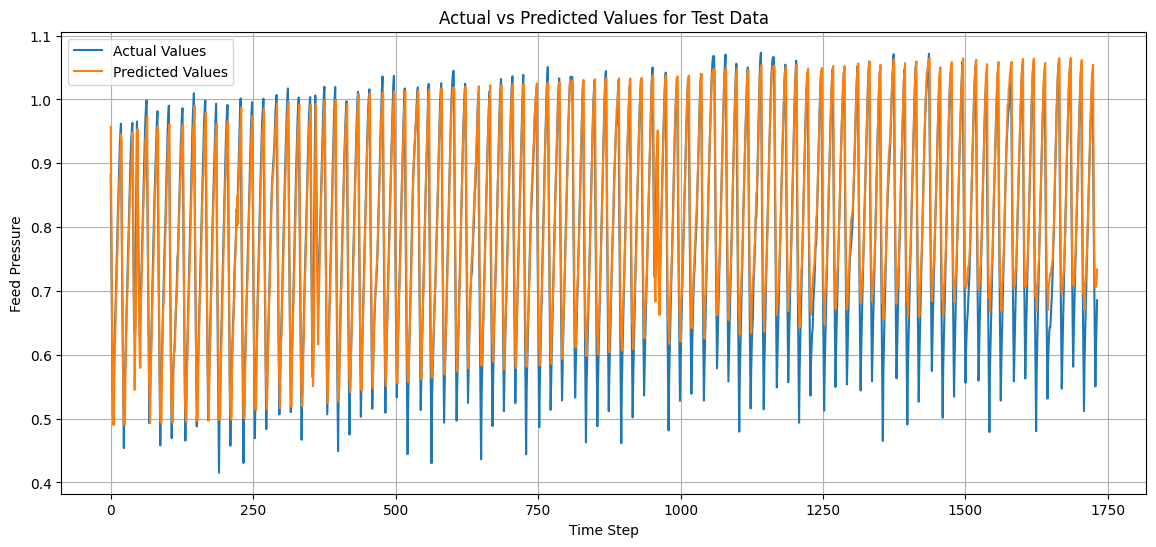

In [ ]:
import matplotlib.pyplot as plt

# 예측 결과 시각화
plt.figure(figsize=(14, 6))
plt.plot(actuals, label='Actual Values', linestyle='-')
plt.plot(predictions, label='Predicted Values', linestyle='-')
plt.xlabel('Time Step')
plt.ylabel('Feed Pressure')
plt.title('Actual vs Predicted Values for Test Data')
plt.legend()
plt.grid(True)  # 그리드를 추가하여 데이터 흐름을 쉽게 파악
plt.show()